## Demonstration of function `resample_in_space()`

This notebook demonstrates the functionality of the `xcube.core.resampling.resample_in_space` function.

In [28]:
import xarray as xr
from xcube.core.gridmapping import GridMapping
from xcube.core.resampling import resample_in_space

---
First configure matplotlib, so we can see no-data vaklues.

In [29]:
import copy
import matplotlib
import matplotlib.pyplot as plt

no_data_color = 'yellow'
# no_data_color = 'red'

gray = copy.copy(matplotlib.cm.get_cmap('gray'))
gray.set_bad(color=no_data_color)

diverging = copy.copy(matplotlib.cm.get_cmap('PRGn'))
# diverging = copy.copy(matplotlib.cm.get_cmap('Spectral'))
diverging.set_bad(color=no_data_color)

In [30]:
def imshow(var):
    var.plot.imshow(figsize=(16,16), vmax=0.25, cmap=gray)

---

In [31]:
%%time
source_ds = xr.open_zarr('../inputdata/S3-OLCI-L2A.zarr.zip')
source_ds

Wall time: 9.99 ms


<xarray.Dataset>
Dimensions:        (x: 1189, y: 1890)
Coordinates:
    lat            (y, x) float64 dask.array<chunksize=(512, 512), meta=np.ndarray>
    lon            (y, x) float64 dask.array<chunksize=(512, 512), meta=np.ndarray>
Dimensions without coordinates: x, y
Data variables:
    quality_flags  (y, x) uint32 dask.array<chunksize=(512, 512), meta=np.ndarray>
    rtoa_3         (y, x) float32 dask.array<chunksize=(512, 512), meta=np.ndarray>
    rtoa_6         (y, x) float32 dask.array<chunksize=(512, 512), meta=np.ndarray>
    rtoa_8         (y, x) float32 dask.array<chunksize=(512, 512), meta=np.ndarray>
Attributes:
    Conventions:   CF-1.4
    product_type:  C2RCC_OLCI
    start_date:    04-JUL-2018 09:21:55.677316
    stop_date:     04-JUL-2018 09:23:18.811790

Wall time: 129 ms


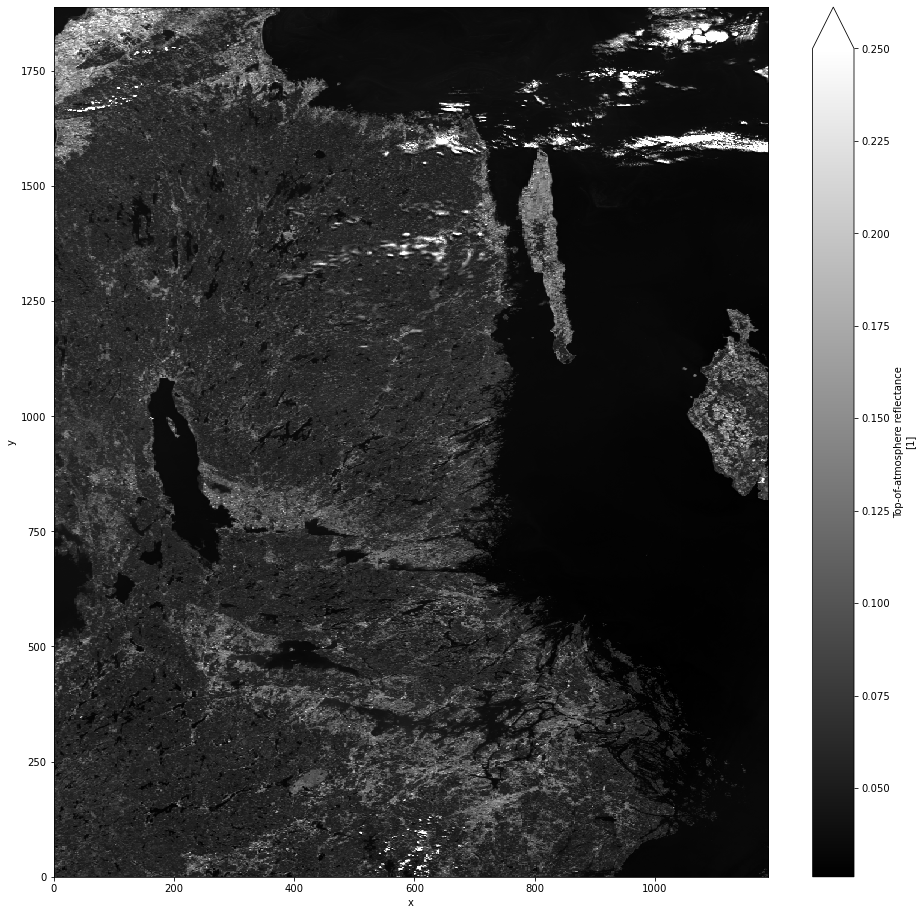

In [32]:
%%time
imshow(source_ds.rtoa_8)

The grid mapping of the dataset uses 2D coordinates `lon` and `lat` both having two dimensions `x` and `y`. This corresponds to satellite viewing geometry. The coordinates in `lon` and `lat` use the spatial coordinate reference system `EPSG:4326`, a geographical coordinate system also referred to as `WGS84`. 

In [33]:
source_gm = GridMapping.from_dataset(source_ds)
source_gm

class: **Coords2DGridMapping**
* is_regular: False
* is_j_axis_up: _unknown_
* is_lon_360: False
* crs: epsg:4326
* xy_res: (0.0025, 0.0025)  _estimated_
* xy_bbox: (12.693050999999999, 55.19893, 20.006134, 60.63943999999999)
* ij_bbox: (0, 0, 1189, 1890)
* xy_dim_names: ('x', 'y')
* xy_var_names: ('lon', 'lat')
* size: (1189, 1890)
* tile_size: (512, 512)

We want to rectify this dataset, so that it uses a regular `EPSG:4326` CRS with 1D coordinates `lon` and `lat` with constant deltas. We therefore create a new target grid mapping as follows:

In [34]:
target_gm = source_gm.to_regular(tile_size=512)
target_gm

class: **RegularGridMapping**
* is_regular: True
* is_j_axis_up: False
* is_lon_360: False
* crs: epsg:4326
* xy_res: (0.0025, 0.0025)
* xy_bbox: (12.693050999999999, 55.19893, 20.008051, 60.64143)
* ij_bbox: (0, 0, 2926, 2177)
* xy_dim_names: ('lon', 'lat')
* xy_var_names: ('lon', 'lat')
* size: (2926, 2177)
* tile_size: (512, 512)

In [35]:
x_coords, y_coords = target_gm.xy_coords
y_coords.values

array([[60.64018, 60.64018, 60.64018, ..., 60.64018, 60.64018, 60.64018],
       [60.63768, 60.63768, 60.63768, ..., 60.63768, 60.63768, 60.63768],
       [60.63518, 60.63518, 60.63518, ..., 60.63518, 60.63518, 60.63518],
       ...,
       [55.20518, 55.20518, 55.20518, ..., 55.20518, 55.20518, 55.20518],
       [55.20268, 55.20268, 55.20268, ..., 55.20268, 55.20268, 55.20268],
       [55.20018, 55.20018, 55.20018, ..., 55.20018, 55.20018, 55.20018]])

Now we resample from source to target:

In [36]:
%%time
target_ds = resample_in_space(source_ds, source_gm=source_gm, target_gm=target_gm)
target_ds

Wall time: 1.07 s


<xarray.Dataset>
Dimensions:        (bnds: 2, lat: 2177, lon: 2926)
Coordinates:
  * lat            (lat) float64 60.64 60.64 60.64 60.63 ... 55.21 55.2 55.2
  * lon            (lon) float64 12.69 12.7 12.7 12.7 ... 20.0 20.0 20.0 20.01
    lon_bnds       (lon, bnds) float64 12.69 12.7 12.7 ... 20.01 20.01 20.01
    lat_bnds       (lat, bnds) float64 60.64 60.64 60.64 ... 55.2 55.2 55.2
Dimensions without coordinates: bnds
Data variables:
    quality_flags  (lat, lon) uint32 dask.array<chunksize=(512, 512), meta=np.ndarray>
    rtoa_3         (lat, lon) float32 dask.array<chunksize=(512, 512), meta=np.ndarray>
    rtoa_6         (lat, lon) float32 dask.array<chunksize=(512, 512), meta=np.ndarray>
    rtoa_8         (lat, lon) float32 dask.array<chunksize=(512, 512), meta=np.ndarray>
Attributes:
    Conventions:   CF-1.4
    product_type:  C2RCC_OLCI
    start_date:    04-JUL-2018 09:21:55.677316
    stop_date:     04-JUL-2018 09:23:18.811790

Wall time: 2.39 s


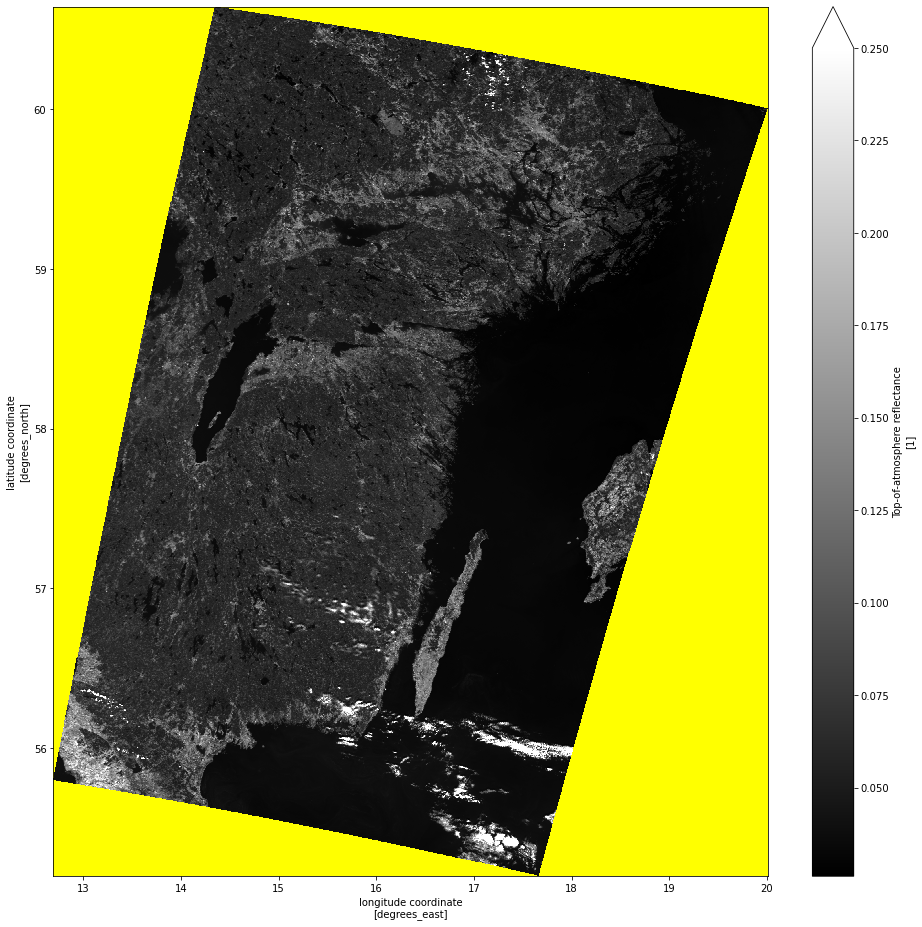

In [37]:
%%time
imshow(target_ds.rtoa_8)

We can also switch to another CRS, for example [UTM 33N](https://epsg.io/32633), also called `EPSG:32633`.

We do not the bounding box and required resolution in UTM coordinates so we first transform the source grid mapping. This will lead to an irrgeular grid mapping that now has 2D UTM coordinates.

In [38]:
temp_utm_target_gm = source_gm.transform("EPSG:32633")
temp_utm_target_gm

class: **Coords2DGridMapping**
* is_regular: False
* is_j_axis_up: _unknown_
* is_lon_360: _unknown_
* crs: EPSG:32633
* xy_res: (200, 200)  _estimated_
* xy_bbox: (355363.34306197613, 6120199.253933037, 779060.8209541705, 6722765.087952104)
* ij_bbox: (0, 0, 1189, 1890)
* xy_dim_names: ('x', 'y')
* xy_var_names: ('transformed_x', 'transformed_y')
* size: (1189, 1890)
* tile_size: (1189, 1890)

We can turn it into a regular one:

In [39]:
utm_target_gm = temp_utm_target_gm.to_regular()
utm_target_gm

class: **RegularGridMapping**
* is_regular: True
* is_j_axis_up: False
* is_lon_360: True
* crs: EPSG:32633
* xy_res: (200, 200)
* xy_bbox: (355363.34306197613, 6120199.253933037, 779163.3430619761, 6722999.253933037)
* ij_bbox: (0, 0, 2119, 3014)
* xy_dim_names: ('x', 'y')
* xy_var_names: ('x', 'y')
* size: (2119, 3014)
* tile_size: (2119, 3014)

Now resample from source to target:

In [40]:
%%time
transformed_target_ds = resample_in_space(source_ds, source_gm=source_gm, target_gm=utm_target_gm)
transformed_target_ds

Wall time: 17.9 s


<xarray.Dataset>
Dimensions:        (bnds: 2, x: 2119, y: 3014)
Coordinates:
  * y              (y) float64 6.723e+06 6.723e+06 ... 6.12e+06 6.12e+06
  * x              (x) float64 3.551e+05 3.553e+05 ... 7.785e+05 7.787e+05
    x_bnds         (x, bnds) float64 3.55e+05 3.552e+05 ... 7.786e+05 7.788e+05
    y_bnds         (y, bnds) float64 6.723e+06 6.723e+06 ... 6.12e+06 6.12e+06
Dimensions without coordinates: bnds
Data variables:
    quality_flags  (y, x) uint32 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
    rtoa_3         (y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
    rtoa_6         (y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
    rtoa_8         (y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
    crs            int32 0
Attributes:
    Conventions:   CF-1.4
    product_type:  C2RCC_OLCI
    start_date:    04-JUL-2018 09:21:55.677316
    stop_date:     04-JUL-2018 09:23:18.811790

Wall time: 93.7 ms


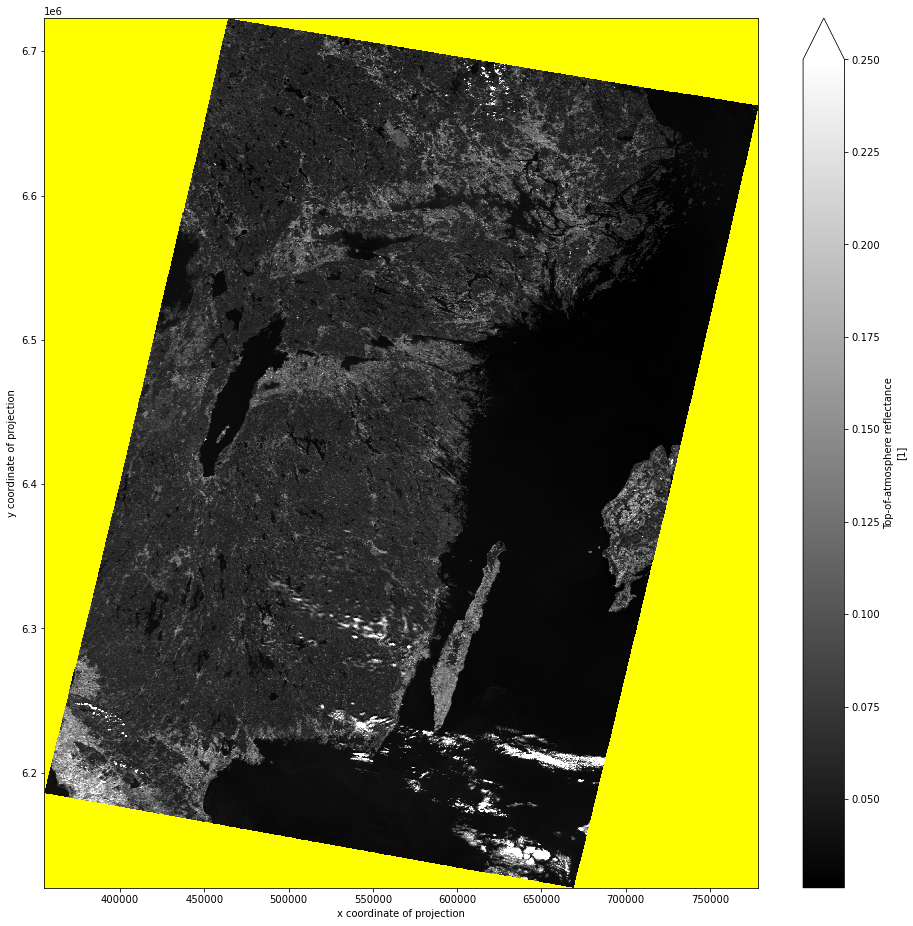

In [43]:
%%time
imshow(transformed_target_ds.rtoa_8)

In [44]:
# target_ds.to_zarr('target_ds.zarr', mode='w')
# target_ds = xr.open_zarr('target_ds.zarr')
# target_ds

The next examples show how to we can apply up- and down-sampling.

In [45]:
downsampled_target_gm = target_gm.scale(0.25, tile_size=128)
downsampled_target_gm

class: **RegularGridMapping**
* is_regular: True
* is_j_axis_up: False
* is_lon_360: False
* crs: epsg:4326
* xy_res: (0.01, 0.01)
* xy_bbox: (12.693050999999999, 55.19893, 20.013050999999997, 60.638929999999995)
* ij_bbox: (0, 0, 732, 544)
* xy_dim_names: ('lon', 'lat')
* xy_var_names: ('lon', 'lat')
* size: (732, 544)
* tile_size: (128, 128)

In [46]:
%%time
downsampled_ds = resample_in_space(target_ds, source_gm=target_gm, target_gm=downsampled_target_gm)
downsampled_ds

Wall time: 7.03 s


<xarray.Dataset>
Dimensions:        (bnds: 2, lat: 544, lon: 732)
Coordinates:
  * lon            (lon) float64 12.7 12.71 12.72 12.73 ... 19.99 20.0 20.01
  * lat            (lat) float64 60.63 60.62 60.61 60.6 ... 55.22 55.21 55.2
    lon_bnds       (lon, bnds) float64 12.69 12.7 12.7 12.71 ... 20.0 20.0 20.01
    lat_bnds       (lat, bnds) float64 60.64 60.63 60.63 ... 55.21 55.21 55.2
Dimensions without coordinates: bnds
Data variables:
    quality_flags  (lat, lon) uint32 dask.array<chunksize=(128, 128), meta=np.ndarray>
    rtoa_3         (lat, lon) float64 dask.array<chunksize=(128, 128), meta=np.ndarray>
    rtoa_6         (lat, lon) float64 dask.array<chunksize=(128, 128), meta=np.ndarray>
    rtoa_8         (lat, lon) float64 dask.array<chunksize=(128, 128), meta=np.ndarray>
Attributes:
    Conventions:   CF-1.4
    product_type:  C2RCC_OLCI
    start_date:    04-JUL-2018 09:21:55.677316
    stop_date:     04-JUL-2018 09:23:18.811790

C:\Users\Norman\Miniconda3\envs\xcube\lib\site-packages\dask\core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
C:\Users\Norman\Miniconda3\envs\xcube\lib\site-packages\dask\array\chunk.py:142: RuntimeWarning: Mean of empty slice
  return reduction(x.reshape(newshape), axis=tuple(range(1, x.ndim * 2, 2)), **kwargs)


Wall time: 2.72 s


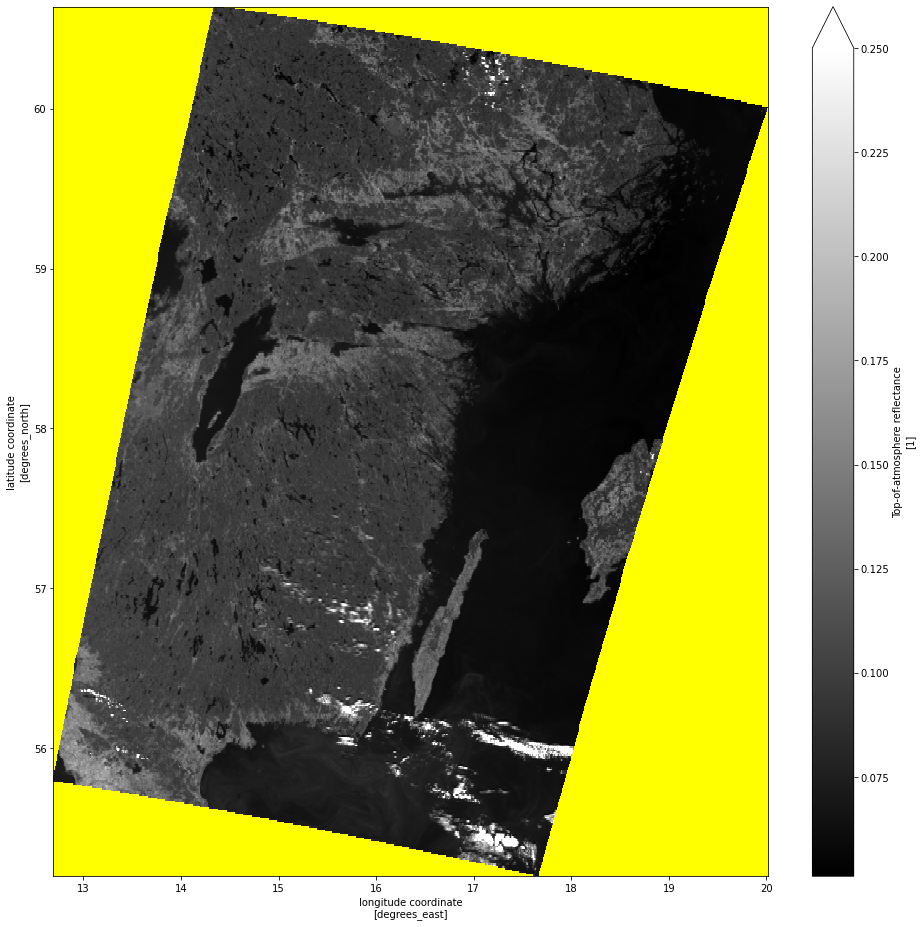

In [47]:
%%time
imshow(downsampled_ds.rtoa_6)

In [48]:
upsampled_target_gm = target_gm.scale(4, tile_size=1024)
upsampled_target_gm

class: **RegularGridMapping**
* is_regular: True
* is_j_axis_up: False
* is_lon_360: False
* crs: epsg:4326
* xy_res: (0.000625, 0.000625)
* xy_bbox: (12.693050999999999, 55.19893, 20.008051, 60.64143)
* ij_bbox: (0, 0, 11704, 8708)
* xy_dim_names: ('lon', 'lat')
* xy_var_names: ('lon', 'lat')
* size: (11704, 8708)
* tile_size: (1024, 1024)

In [49]:
%%time
upsampled_target_gm = resample_in_space(target_ds, source_gm=target_gm, target_gm=upsampled_target_gm)
upsampled_target_gm

Wall time: 7.32 s


<xarray.Dataset>
Dimensions:        (bnds: 2, lat: 8708, lon: 11704)
Coordinates:
  * lon            (lon) float64 12.69 12.69 12.69 12.7 ... 20.01 20.01 20.01
  * lat            (lat) float64 60.64 60.64 60.64 60.64 ... 55.2 55.2 55.2 55.2
    lon_bnds       (lon, bnds) float64 12.69 12.69 12.69 ... 20.01 20.01 20.01
    lat_bnds       (lat, bnds) float64 60.64 60.64 60.64 ... 55.2 55.2 55.2
Dimensions without coordinates: bnds
Data variables:
    quality_flags  (lat, lon) uint32 dask.array<chunksize=(1024, 1024), meta=np.ndarray>
    rtoa_3         (lat, lon) float64 dask.array<chunksize=(1024, 1024), meta=np.ndarray>
    rtoa_6         (lat, lon) float64 dask.array<chunksize=(1024, 1024), meta=np.ndarray>
    rtoa_8         (lat, lon) float64 dask.array<chunksize=(1024, 1024), meta=np.ndarray>
Attributes:
    Conventions:   CF-1.4
    product_type:  C2RCC_OLCI
    start_date:    04-JUL-2018 09:21:55.677316
    stop_date:     04-JUL-2018 09:23:18.811790

C:\Users\Norman\Miniconda3\envs\xcube\lib\site-packages\dask\core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


Wall time: 8.63 s


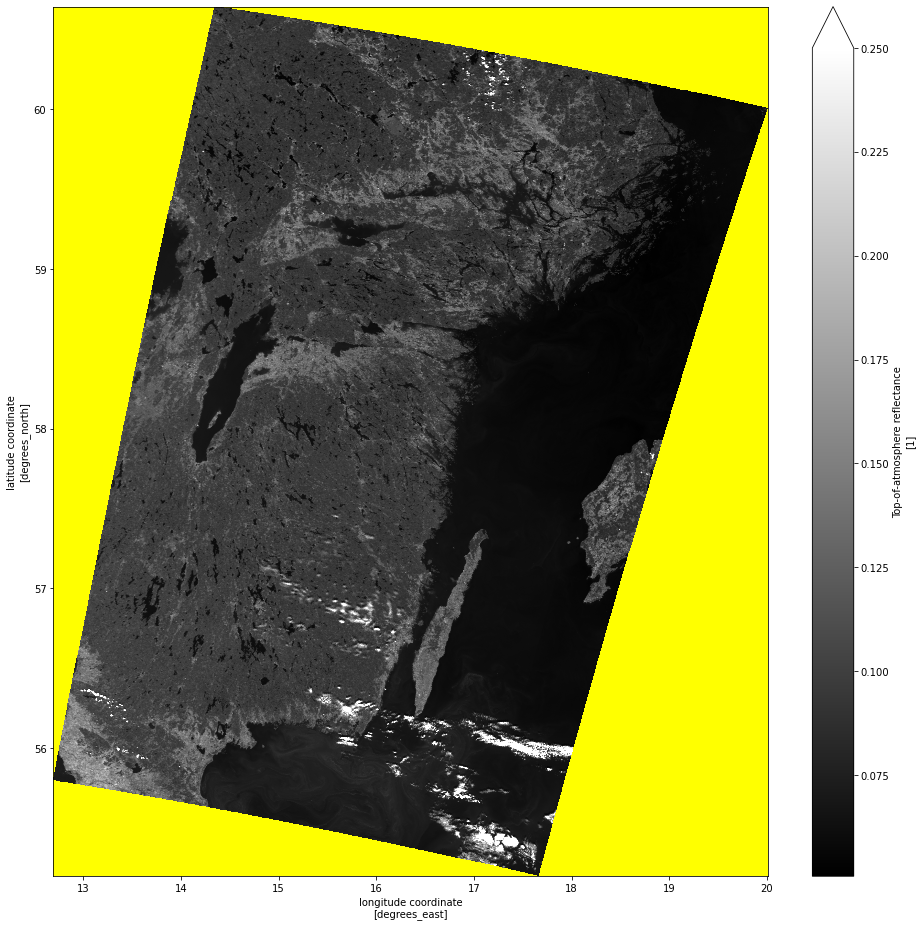

In [50]:
%%time
imshow(upsampled_target_gm.rtoa_6)

In [51]:
from pyproj.crs import CRS

In [52]:
crs = CRS.from_string('EPSG:4326')

In [53]:
crs.axis_info[0]

Axis(name=Geodetic latitude, abbrev=Lat, direction=north, unit_auth_code=EPSG, unit_code=9122, unit_name=degree)

In [54]:
crs.axis_info[0].name


'Geodetic latitude'